# Goal

The goal of this notebook is to perform automatic segmentation.

- get only the brain
- perform automatic segmentation

Realized that this is extremely difficult so changing tactics and I am going to do it for each slice.

This is done and it can be seen in the folder **JPG Stack Cortex Segmentation** located here:
- **C:\Cerebral\_MarioSandBox\DB\medicalHolography\Animal Brains\Monkey\JPG Stack Cortex Segmentation**

# Background

- [DB](http://www.chimpanzeebrain.org/mri-datasets-for-direct-download)
- [Simple ITK Image Basics](http://simpleitk.github.io/SimpleITK-Notebooks/01_Image_Basics.html)

I will try to following these VTK and ITK tutorials:
- [Image Segmentation with Python and SimpleITK](https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/)
    - [Jupyter notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/somada141/pyscience/raw/master/20141001_SegmentationSimpleITK/Material/SegmentationSimpleITK.ipynb)
    
Articles to read:
- [MRI Segmentation of the Human Brain: Challenges, Methods, and Applications](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4402572/)
- [Automatic Segmentation of Newborn Brain MRI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2945911/)
- [Methods on Skull Stripping of MRI Head Scan Images—a Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4879034/)

# Imports

In [1]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.ndimage
import scipy.misc

# Functions

In [3]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [4]:
def showSegmentation(sliceNum=90):
    # Get slice
    idxSlice = sliceNum
    imgOriginal = image[:,:,idxSlice]

    # Apply smoothing
    imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                        timeStep=0.125,
                                        numberOfIterations=5)
    sitk_show(imgSmooth)

    # Get segmentation
    lstSeeds = [(75,60)]

    imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                                  seedList=lstSeeds, 
                                                  lower=0, 
                                                  upper=40,
                                                  replaceValue=labelWhiteMatter)

    # Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
    imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

    # Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
    sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

    # show segmentation
    sitk_show(imgWhiteMatter)

In [5]:
def getMask(sliceImage,pxlRanges):
#     sliceImage = np.copy(grayMatterMask[:,:,50])
    xLen,yLen = np.shape(sliceImage)
#     pxlRanges = grayMatterRange
    lower = pxlRanges[0]
    upper = pxlRanges[1]

    for x in xrange(xLen):
        for y in xrange(yLen):        
            if(sliceImage[x,y]>=lower and sliceImage[x,y]<=upper):                        
                sliceImage[x,y] = 1.0
            else:
                sliceImage[x,y] = 0.0
    
    return sliceImage

# Parameters

In [6]:
inpath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Monkey//10 sample Chimpanzee 3T for NCBR website//Male_Fritz.nii'
# inpath = "C://Cerebral//_MarioSandBox//DB//medicalHolography//UofT Mouse Brain//C57brain.mnc"

In [7]:
segmentationDir = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stack Cortex Segmentation//'

In [8]:
# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 50

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

# Reading Data

Lets read the entire Dir into a 256 x 256 x num Slice array so that it is easier to navigate

In [9]:
startSlice = 17
endSlice = 105
sliceInd = range(startSlice,endSlice+1)

In [10]:
data = np.zeros((256,256,len(sliceInd)))

In [11]:
sliceNum = 0
for ind in sliceInd:         
    fileLocation = segmentationDir
    fileName = '{}.jpg'.format(ind)
    img = scipy.ndimage.imread(fileLocation+fileName)
    try:
        data[:,:,sliceNum] = img[:,:,0]
    except:
        data[:,:,sliceNum] = img
    sliceNum = sliceNum+1

C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """


Quick check to see if data is consistant

In [12]:
np.shape(data)

(256L, 256L, 89L)

Let us look at a couple of slices 

Text(0.5,1,'Showing Slice 85')

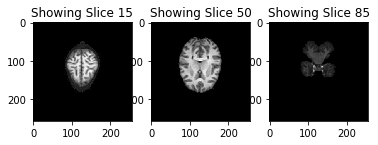

In [13]:
plt.subplot(1,3,1)
sliceShowInd = 15
plt.set_cmap("gray")
plt.imshow(data[:,:,sliceShowInd])
plt.title('Showing Slice {}'.format(sliceShowInd))
plt.subplot(1,3,2)
sliceShowInd = 50
plt.set_cmap("gray")
plt.imshow(data[:,:,sliceShowInd])
plt.title('Showing Slice {}'.format(sliceShowInd))
plt.subplot(1,3,3)
sliceShowInd = 85
plt.set_cmap("gray")
plt.imshow(data[:,:,sliceShowInd])
plt.title('Showing Slice {}'.format(sliceShowInd))

This looks really good so far so now let us look at this histogram distribution.  Note that with out crude segmentation we thought the follow segmentation 
- Gray Matter : [90-200]
- White Matter : [40-90]

Let us see if these hold

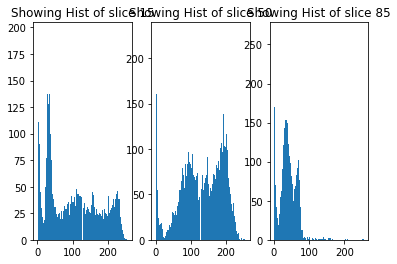

In [14]:
sliceShowInd = [15,50,85]
count = 0

for sInd in sliceShowInd:
    plt.subplot(1,3,count+1)
    # note that this is not from 0-256 but rather from 1 - 255 because we want to ignore the background
    plt.hist(data[:,:,sInd].ravel(),256,[1,255]); 
    plt.title('Showing Hist of slice {}'.format(sInd))
#     plt.show()   
    
    count = count + 1 

This distribution is exactly what we'd expect when looking at the histogram.  There are 3 distict peaks which corresponds to 
- White Matter (WM)
- Gray Matter (GM)
- cerebrospinal fluid (CSF)

see image below: 

![](https://openi.nlm.nih.gov/imgs/512/394/4402572/PMC4402572_CMMM2015-450341.008.png)

Notice the inconsistency of each of the distribution in each of the slices.  In a perfect world you'd expect these to be all the same but they are not. Slice 85 in particular look like it has not white white matter but it does, but the image is just darker.  This means we have to perform histogram manipulation to perform proper segmentation.  But before we go into this let us use our previous visual inspection method and see if segmentation is adequate here. 

# Segmentation

In [15]:
grayMatterRange = [95.0,188.0]
whiteMatterRange = [190.0,255.0]

grayMatterMask = np.copy(data)
whiteMatterMask = np.copy(data)

x,y,numSlices = np.shape(data)

In [16]:
for ind in xrange(numSlices):         
    # Gray Matter Mask Generation
    grayMatterMask[:,:,ind] = getMask(grayMatterMask[:,:,ind],grayMatterRange)
    
    # White Matter Mask Generation
    whiteMatterMask[:,:,ind] = getMask(whiteMatterMask[:,:,ind],whiteMatterRange)    

Let us see the masks for this.

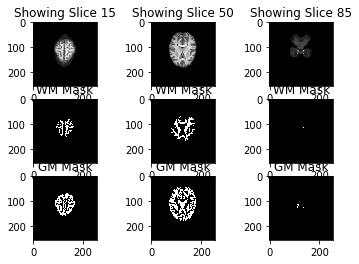

In [17]:
sliceShowInd = [15,50,85]
count = 1

for sInd in sliceShowInd:
    # Slice
    plt.subplot(3,3,count)
    plt.set_cmap("gray")
    plt.imshow(data[:,:,sInd])
    plt.title('Showing Slice {}'.format(sInd))    
    
    #Mask White Matter
    plt.subplot(3,3,count+3)
    plt.set_cmap("gray")
    plt.imshow(whiteMatterMask[:,:,sInd]*255.0)
    plt.title('WM Mask') 
    
    #Mask Gray Matter
    plt.subplot(3,3,count+6)
    plt.set_cmap("gray")
    plt.imshow(grayMatterMask[:,:,sInd]*255.0)
    plt.title('GM Mask')  
    
    
    count = count + 1     


Alright this looks good so let us output these into two separte file locations for documentation purpose but the next step would be to create the model.

# Save File

In [18]:
gmOutMask = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Mask - Gray Matter//'
gmMasked = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stack Gray Matter Segmentation//'

wmOutMask = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Mask - White Matter//'
wmMaksed = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stack White Matter Segmentation//'

In [19]:
for sInd in xrange(numSlices):    
    
    #White Matter
    # Mask
    mask = whiteMatterMask[:,:,sInd]*255.0
    scipy.misc.imsave(wmOutMask+'{}.jpg'.format(sInd), mask)
    # Masked image
    maskedImage = whiteMatterMask[:,:,sInd] * data[:,:,sInd]
    scipy.misc.imsave(wmMaksed+'{}.jpg'.format(sInd), maskedImage)
    
    #Gray Matter
    # Mask
    mask = grayMatterMask[:,:,sInd]*255.0
    scipy.misc.imsave(gmOutMask+'{}.jpg'.format(sInd), mask)
    # Masked image
    maskedImage = grayMatterMask[:,:,sInd] * data[:,:,sInd]
    scipy.misc.imsave(gmMasked+'{}.jpg'.format(sInd), maskedImage)
    

C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':
C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
